In [1]:
import yfinance as yf 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models, objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

plt.style.use('seaborn-darkgrid')

In [2]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'NVDA', 'JNJ', 'FB', 'PG', 'JPM', 'XOM']
data = yf.download(tickers=tickers, period='5y', interval='1d', auto_adjust=True).Close
data 

[*********************100%***********************]  10 of 10 completed


,AAPL,FB,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TSLA,XOM
Date,,,,,,,,,,
2017-04-27,33.940186,147.699997,891.440002,108.467911,76.275414,63.729008,26.094877,76.396408,61.726002,62.456696
2017-04-28,33.907146,150.250000,924.520020,108.231224,75.744316,63.906368,25.763884,76.082771,62.813999,62.756432
2017-05-01,34.598740,152.460007,932.820007,108.117264,75.796547,64.793198,26.341896,75.873672,64.566002,63.071571
2017-05-02,34.818268,152.779999,937.090027,108.432854,75.308990,64.690506,25.561327,75.115707,63.778000,63.063885
2017-05-03,34.712040,151.800003,948.450012,108.108521,75.744316,64.485130,25.751524,75.298683,62.203999,63.563454
...,...,...,...,...,...,...,...,...,...,...
2022-04-20,167.229996,200.419998,2560.800049,183.889999,131.580002,286.359985,214.820007,162.736984,977.200012,87.959999
2022-04-21,166.419998,188.070007,2496.290039,183.360001,130.559998,280.809998,201.830002,162.610001,1008.780029,87.029999
2022-04-22,161.789993,184.110001,2392.709961,181.539993,126.809998,274.029999,195.149994,161.250000,1005.049988,85.129997


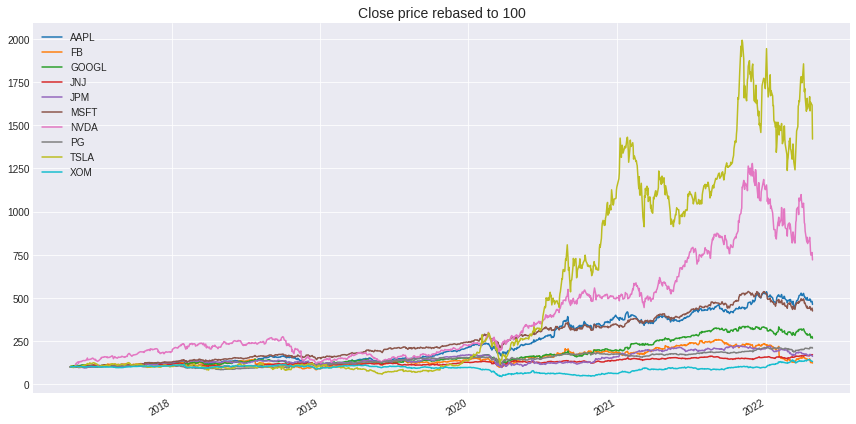

In [3]:
ax = (data/data.iloc[0]*100).plot(figsize=(12,6), xlabel='')
ax.set_title('Close price rebased to 100', fontsize=14)
plt.tight_layout()
plt.show()

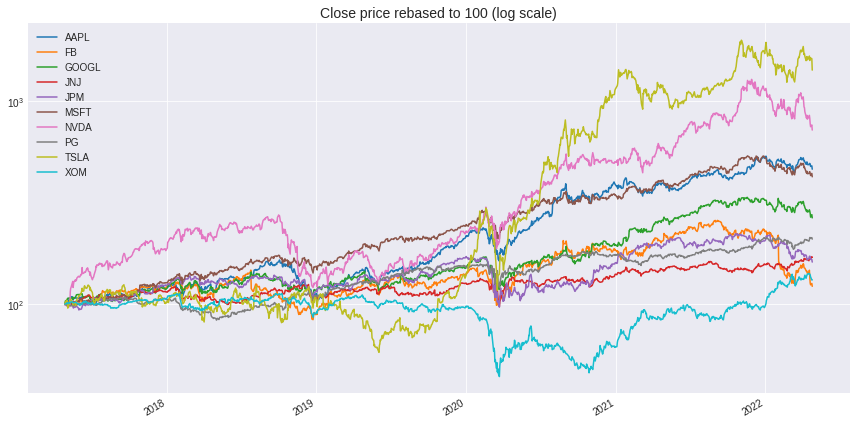

In [4]:
ax = (data/data.iloc[0]*100).plot(figsize=(12,6), xlabel='', )
ax.set_title('Close price rebased to 100 (log scale)', fontsize=14)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

# Processing historical prices

In [5]:
mu = expected_returns.mean_historical_return(data, frequency=252, log_returns=True)
mu 

AAPL     0.293825
FB      -0.033385
GOOGL    0.168524
JNJ      0.089325
JPM      0.049545
MSFT     0.281562
NVDA     0.314056
PG       0.135116
TSLA     0.400753
XOM      0.005808
dtype: float64

In [6]:
S = risk_models.CovarianceShrinkage(data, frequency=252, log_returns=True).ledoit_wolf()
S 

,AAPL,FB,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TSLA,XOM
AAPL,0.097825,0.065740,0.058446,0.024858,0.042088,0.065813,0.093989,0.025103,0.083759,0.032048
FB,0.065740,0.141999,0.069602,0.020060,0.038639,0.066054,0.099423,0.018447,0.076766,0.028468
GOOGL,0.058446,0.069602,0.081288,0.022664,0.040445,0.063433,0.086712,0.020944,0.066573,0.033277
JNJ,0.024858,0.020060,0.022664,0.043426,0.025832,0.026871,0.027137,0.024311,0.016529,0.022871
JPM,0.042088,0.038639,0.040445,0.025832,0.095003,0.041574,0.053881,0.022820,0.048544,0.059269
MSFT,0.065813,0.066054,0.063433,0.026871,0.041574,0.082831,0.094748,0.026219,0.078439,0.029127
NVDA,0.093989,0.099423,0.086712,0.027137,0.053881,0.094748,0.239408,0.026331,0.130365,0.039383
PG,0.025103,0.018447,0.020944,0.024311,0.022820,0.026219,0.026331,0.043737,0.017012,0.017878
TSLA,0.083759,0.076766,0.066573,0.016529,0.048544,0.078439,0.130365,0.017012,0.381220,0.037114
XOM,0.032048,0.028468,0.033277,0.022871,0.059269,0.029127,0.039383,0.017878,0.037114,0.099112


# Mean-variance optimization

$portfolio \; return = w^{T}\mu$ <br>
$portfolio \; risk = w^{T}\Sigma w$ <br>

$$\underset{w}{minimize} \quad w^{T}\Sigma w $$
$$subject \: to \quad w^{T}\mu \geq \mu^{*}$$
$$\quad\quad\quad\quad w^{T}1 = 1$$
$$\quad\quad\quad\quad w_{i} \geq 0$$

In [7]:
ef = EfficientFrontier(mu, S)

In [8]:
# get weights that maximize sharpe ratio
weights = ef.max_sharpe()

In [9]:
for ticker, weight in weights.items():
    print(f"{ticker:5s} ---> {weight*100:.2f}%")
print('-'*20)
print(f"Total {np.sum(list(weights.values()))*100:.2f}%")
print('='*20)

AAPL  ---> 29.84%
FB    ---> 0.00%
GOOGL ---> 0.00%
JNJ   ---> 0.00%
JPM   ---> 0.00%
MSFT  ---> 39.64%
NVDA  ---> 0.00%
PG    ---> 21.23%
TSLA  ---> 9.28%
XOM   ---> 0.00%
--------------------
Total 100.00%


In [10]:
weights_df = pd.DataFrame(weights.items()).rename(columns={0:'Tickers', 1:'Weights'}).set_index('Tickers')
weights_df.sort_values(by='Weights', inplace=True)
weights_df

,Weights
Tickers,
FB,0.000000
GOOGL,0.000000
JNJ,0.000000
JPM,0.000000
NVDA,0.000000
XOM,0.000000
TSLA,0.092836
PG,0.212306
AAPL,0.298408


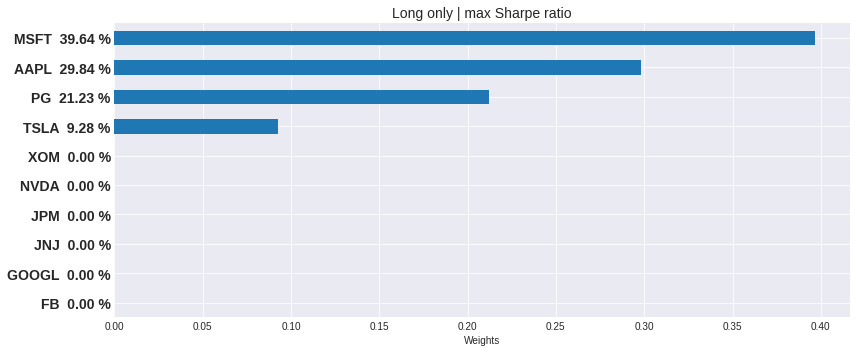

In [11]:
ax = weights_df.plot(kind='barh', legend='', figsize=(12,5))

# for p, w in zip(ax.patches, weights_df.Weights.values):
#     x = p.get_width() + 0.005
#     y = p.get_y() + p.get_height()/2
#     ax.annotate(f"{w*100:.2f} %", (x,y), fontsize=14, fontweight='bold')

new_labels = []
for t, w in zip(weights_df.index.values, weights_df.Weights.values):
    new_labels.append(f"{t}  {w*100:.2f} %")

ax.set_yticks(range(len(weights_df)), new_labels, fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Weights')
ax.set_title('Long only | max Sharpe ratio', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# performance of the weights that maximized sharpe ratio
ef.portfolio_performance(verbose=True)

Expected annual return: 26.5%
Annual volatility: 24.7%
Sharpe Ratio: 0.99


(0.26519495224911394, 0.2474639230723795, 0.990831104610744)

# Short positions

In [13]:
# to allow short position --> set weight_bounds to (-1,1)
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

In [14]:
weights = ef.max_sharpe()

In [15]:
for ticker, weight in weights.items():
    print(f"{ticker:5s} ---> {weight*100:.2f}%")
print('-'*20)
print(f"Total {np.sum(list(weights.values()))*100:.2f}%")
print('='*20)

AAPL  ---> 80.66%
FB    ---> -100.00%
GOOGL ---> 12.33%
JNJ   ---> -7.82%
JPM   ---> -33.73%
MSFT  ---> 100.00%
NVDA  ---> 5.98%
PG    ---> 51.14%
TSLA  ---> 16.03%
XOM   ---> -24.58%
--------------------
Total 100.00%


In [16]:
ef.portfolio_performance(verbose=True)

Expected annual return: 70.0%
Annual volatility: 46.6%
Sharpe Ratio: 1.46


(0.6997110225006511, 0.4663043304111637, 1.4576553940670378)

In [17]:
weights_df = pd.DataFrame(weights.items()).rename(columns={0:'Tickers', 1:'Weights'}).set_index('Tickers')
weights_df.sort_values(by='Weights', inplace=True)
weights_df

,Weights
Tickers,
FB,-1.000000
JPM,-0.337347
XOM,-0.245835
JNJ,-0.078178
NVDA,0.059760
GOOGL,0.123283
TSLA,0.160310
PG,0.511390
AAPL,0.806617


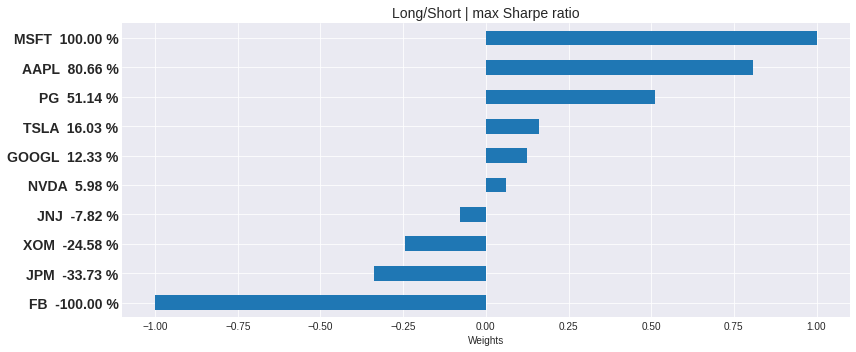

In [18]:
ax = weights_df.plot(kind='barh', legend='', figsize=(12,5))

new_labels = []
for t, w in zip(weights_df.index.values, weights_df.Weights.values):
    new_labels.append(f"{t}  {w*100:.2f} %")

ax.set_yticks(range(len(weights_df)), new_labels, fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Weights')
ax.set_title('Long/Short | max Sharpe ratio', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

## Market Neutral

In [19]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

In [20]:
target_ret = 0.2
weights = ef.efficient_return(target_return=target_ret, market_neutral=True)

In [21]:
for ticker, weight in weights.items():
    print(f"{ticker:5s} ---> {weight*100:.2f}%")
print('-'*20)
print(f"Total {np.sum(list(weights.values()))*100:.2f}%")
print('='*20)

AAPL  ---> 23.79%
FB    ---> -34.91%
GOOGL ---> -1.64%
JNJ   ---> -14.53%
JPM   ---> -11.35%
MSFT  ---> 39.08%
NVDA  ---> 2.99%
PG    ---> 3.10%
TSLA  ---> 4.20%
XOM   ---> -10.73%
--------------------
Total 0.00%


In [22]:
ef.portfolio_performance(verbose=True)

Expected annual return: 20.0%
Annual volatility: 14.2%
Sharpe Ratio: 1.26


(0.19999999999999996, 0.1424763587364981, 1.26336749195633)

In [23]:
weights_df = pd.DataFrame(weights.items()).rename(columns={0:'Tickers', 1:'Weights'}).set_index('Tickers')
weights_df.sort_values(by='Weights', inplace=True)
weights_df

,Weights
Tickers,
FB,-0.349104
JNJ,-0.145263
JPM,-0.113506
XOM,-0.107296
GOOGL,-0.016413
NVDA,0.029877
PG,0.031005
TSLA,0.041951
AAPL,0.237947


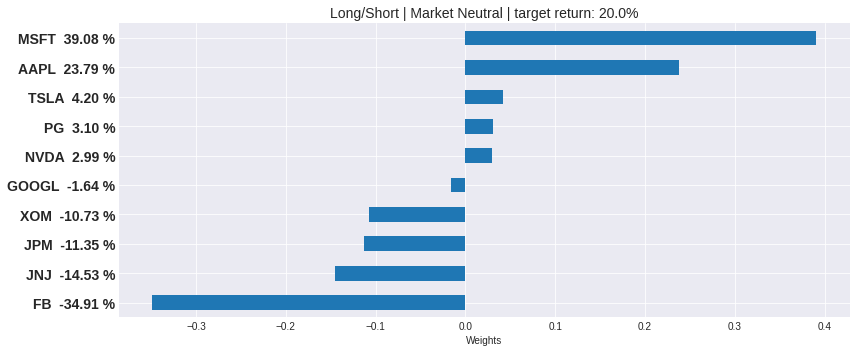

In [24]:
ax = weights_df.plot(kind='barh', legend='', figsize=(12,5))

new_labels = []
for t, w in zip(weights_df.index.values, weights_df.Weights.values):
    new_labels.append(f"{t}  {w*100:.2f} %")

ax.set_yticks(range(len(weights_df)), new_labels, fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Weights')
ax.set_title(f'Long/Short | Market Neutral | target return: {target_ret*100}%', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
target_vol = 0.25
weights = ef.efficient_risk(target_volatility=target_vol, market_neutral=True)

In [26]:
for ticker, weight in weights.items():
    print(f"{ticker:5s} ---> {weight*100:.2f}%")
print('-'*20)
print(f"Total {np.sum(list(weights.values()))*100:.2f}%")
print('='*20)

AAPL  ---> 41.75%
FB    ---> -61.26%
GOOGL ---> -2.88%
JNJ   ---> -25.49%
JPM   ---> -19.92%
MSFT  ---> 68.57%
NVDA  ---> 5.24%
PG    ---> 5.44%
TSLA  ---> 7.36%
XOM   ---> -18.83%
--------------------
Total -0.00%


In [27]:
ef.portfolio_performance(verbose=True)

Expected annual return: 35.1%
Annual volatility: 25.0%
Sharpe Ratio: 1.32


(0.35093541429645947, 0.24999999990435695, 1.3237416576922645)

In [28]:
weights_df = pd.DataFrame(weights.items()).rename(columns={0:'Tickers', 1:'Weights'}).set_index('Tickers')
weights_df.sort_values(by='Weights', inplace=True)
weights_df

,Weights
Tickers,
FB,-0.612564
JNJ,-0.254889
JPM,-0.199167
XOM,-0.188269
GOOGL,-0.028802
NVDA,0.052424
PG,0.054403
TSLA,0.073610
AAPL,0.417518


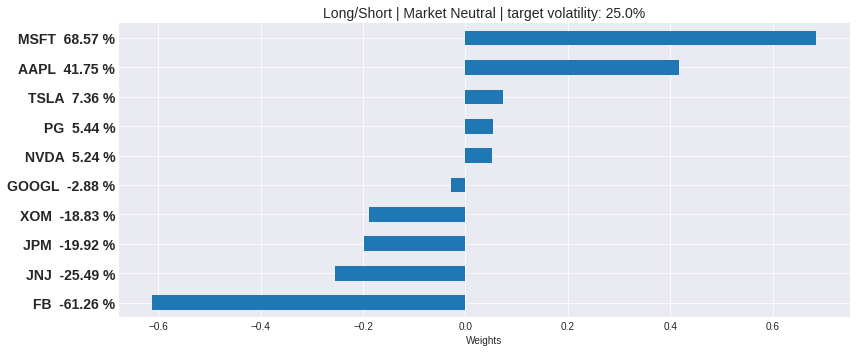

In [29]:
ax = weights_df.plot(kind='barh', legend='', figsize=(12,5))

new_labels = []
for t, w in zip(weights_df.index.values, weights_df.Weights.values):
    new_labels.append(f"{t}  {w*100:.2f} %")

ax.set_yticks(range(len(weights_df)), new_labels, fontweight='bold')
ax.set_ylabel('')
ax.set_xlabel('Weights')
ax.set_title(f'Long/Short | Market Neutral | target volatility: {target_vol*100}%', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Dealing with many negligible weights
* reduce number of 0% weight

In [30]:
ef = EfficientFrontier(mu, S)
# add L2 regularization
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights_L2 = ef.max_sharpe()
weights_L2_df = pd.DataFrame(weights_L2.items()).rename(columns={0:'Tickers', 1:'Weights'})#.set_index('Tickers')
weights_L2_df.sort_values(by='Weights', inplace=True)
weights_L2_df['objective'] = 'L2 reg'
weights_L2_df

/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


,Tickers,Weights,objective
1,FB,0.000000,L2 reg
2,GOOGL,0.000000,L2 reg
4,JPM,0.000000,L2 reg
9,XOM,0.000000,L2 reg
3,JNJ,0.014125,L2 reg
6,NVDA,0.084613,L2 reg
7,PG,0.157740,L2 reg
8,TSLA,0.168805,L2 reg
0,AAPL,0.285867,L2 reg
5,MSFT,0.288850,L2 reg


In [31]:
# compare with no objective

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
weights_df = pd.DataFrame(weights.items()).rename(columns={0:'Tickers', 1:'Weights'})#.set_index('Tickers')
weights_df.sort_values(by='Weights', inplace=True)
weights_df['objective'] = 'None'
weights_df

,Tickers,Weights,objective
1,FB,0.000000,None
2,GOOGL,0.000000,None
3,JNJ,0.000000,None
4,JPM,0.000000,None
6,NVDA,0.000000,None
9,XOM,0.000000,None
8,TSLA,0.092836,None
7,PG,0.212306,None
0,AAPL,0.298408,None
5,MSFT,0.396449,None


In [32]:
weights_combine = pd.concat([weights_L2_df, weights_df], axis=0)

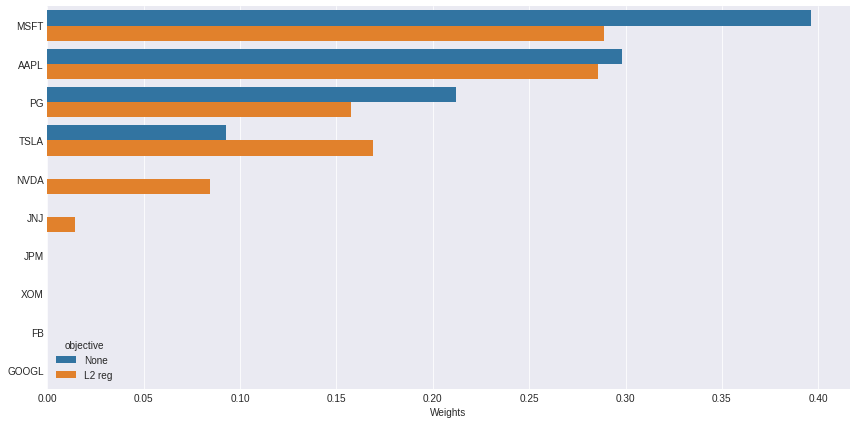

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=weights_combine.sort_values(by='Weights', ascending=False), 
            x='Weights', y='Tickers', hue='objective', ax=ax)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Post-processing weights

In [34]:
lastest_prices = get_latest_prices(data)
lastest_prices

AAPL      156.800003
FB        180.949997
GOOGL    2373.000000
JNJ       184.679993
JPM       123.019997
MSFT      270.220001
NVDA      187.880005
PG        159.789993
TSLA      876.419983
XOM        82.290001
Name: 2022-04-26 00:00:00, dtype: float64

In [35]:
da = DiscreteAllocation(weights=weights_L2, 
                        latest_prices=lastest_prices,
                        total_portfolio_value=50000)

In [36]:
da.greedy_portfolio(verbose=True)

Funds remaining: 128.23
MSFT: allocated 0.287, desired 0.289
AAPL: allocated 0.286, desired 0.286
TSLA: allocated 0.176, desired 0.169
PG: allocated 0.157, desired 0.158
NVDA: allocated 0.083, desired 0.085
JNJ: allocated 0.011, desired 0.014
FB: allocated 0.000, desired 0.000
GOOGL: allocated 0.000, desired 0.000
JPM: allocated 0.000, desired 0.000
XOM: allocated 0.000, desired 0.000
Allocation has RMSE: 0.003


({'MSFT': 53, 'AAPL': 91, 'TSLA': 10, 'PG': 49, 'NVDA': 22, 'JNJ': 3},
 128.23007202148438)

In [37]:
da.lp_portfolio(verbose=True)

Funds remaining: 4.88
MSFT: allocated 0.465, desired 0.289
AAPL: allocated 0.229, desired 0.286
TSLA: allocated 0.066, desired 0.169
PG: allocated 0.125, desired 0.158
NVDA: allocated 0.112, desired 0.085
JNJ: allocated 0.003, desired 0.014
FB: allocated 0.000, desired 0.000
GOOGL: allocated 0.000, desired 0.000
JPM: allocated 0.000, desired 0.000
XOM: allocated 0.000, desired 0.000
Allocation has RMSE: 0.068


({'MSFT': 92, 'AAPL': 78, 'TSLA': 4, 'PG': 42, 'NVDA': 32, 'JNJ': 1},
 4.88037109375)